In [1]:
# ===================================
# !!! SET UP PATH AND MERGE FILES !!!
# ===================================

import csv
import numpy as np
import pandas as pd
from astropy import units as u
from astropy.coordinates import SkyCoord
import os

Nchunk = 20
trials = 1e4
directory = '/home/ambra/Desktop/cluster-morgana/archive_tests/tesi_01_preliminary/'
nfolders = ['tesi_preliminary_nominal_noEBL/', 'tesi_preliminary_nominal_EBL/']
dfolders = ['tesi_preliminary_degraded_noEBL/', 'tesi_preliminary_degraded_EBL/']
folders = nfolders + dfolders

print(dfolders, nfolders, folders)

['tesi_preliminary_degraded_noEBL/', 'tesi_preliminary_degraded_EBL/'] ['tesi_preliminary_nominal_noEBL/', 'tesi_preliminary_nominal_EBL/'] ['tesi_preliminary_nominal_noEBL/', 'tesi_preliminary_nominal_EBL/', 'tesi_preliminary_degraded_noEBL/', 'tesi_preliminary_degraded_EBL/']


In [2]:
for i, f in enumerate(folders):
    os.system('mkdir %s/png' %(directory+f))
    path = directory + f + 'run0406/run0406_ID000126/csv/'

    texp = [1,5,10,100]
    sigma = [5]
    chunk = [i+1 for i in range(Nchunk)]

    csvName = [[]*i for i in range(len(texp))]
    for i in range(len(chunk)) :  
        for j in range(len(texp)) :
            csvName[j].append('run0406_%ds_chunk%02d.csv' % (texp[j], chunk[i]))
            
    # merge files ---!
    csvMerged = []
    for j in range(len(texp)) :
        csvMerged.append('run0406_%ds.csv' %texp[j])

        fout = open(path+csvMerged[j],'w+')
        # first file ---!
        for line in open(path+csvName[j][0]):
            fout.write(line)
        # remaining files ---!    
        for i in range(len(chunk)-1):
            f = open(path+csvName[j][i+1])
            next(f) # skip the header ---!
            for line in f:
                 fout.write(line)
            f.close() 
        fout.close()

    print(csvMerged)
print('done')

['run0406_1s.csv', 'run0406_5s.csv', 'run0406_10s.csv', 'run0406_100s.csv']
['run0406_1s.csv', 'run0406_5s.csv', 'run0406_10s.csv', 'run0406_100s.csv']
['run0406_1s.csv', 'run0406_5s.csv', 'run0406_10s.csv', 'run0406_100s.csv']
['run0406_1s.csv', 'run0406_5s.csv', 'run0406_10s.csv', 'run0406_100s.csv']
done


In [6]:
# reformat files ---!
#for f in csvMerged:
#    with open(path+f, 'r') as inp, open(path+f.replace('.csv', '_mod.csv'), 'w') as out:
#        writer = csv.writer(out)
#        for row in csv.reader(inp):
#            if len(row) == 6 and ('ID' in row[0] or '#' in row[0]):
#                writer.writerow(row)


#for index, f in enumerate(csvMerged):
#    csvMerged[index] = f.replace('.csv', '_mod.csv')
#print(csvMerged)

In [3]:
# data params ---!
threshold = 0.5
xlim=0.2
# initialize SphDistance calc ---!
trueRA = 33.057
trueDEC = -51.841
true_coord = SkyCoord(ra = trueRA*u.deg, dec = trueDEC*u.deg, frame='fk5')

In [6]:
# ------------------------------------------ plots ---!
def plottage(texp, ra, dec, pos, std_ra, std_dec, std_pos, trueRA, trueDEC, png_path):
    '''
    All parameter histograms.
    '''

    c = ['darkgreen', 'red', 'navy', 'gold']
    alpha = 0.3
    hist=True
    
    # conf intervals params ---!
    nstd = [1,2,3,5]
    conf_probs = [0.6827, 0.9545, 0.9973, 0.99994]
    # img params ---!
    fontsize=12
    CI_colors = ['k', 'r', 'g', 'w']
    leglabel = ['texp=%ds' %texp[i] for i in range(len(texp))]

    # DETECTION 1D ---!
    fig, ax = hist1d_gauss(ra, mean=None, loc=trueRA, threshold=threshold, nbin=Dnbin, width=Dwidth,
                           fontsize=fontsize, color=c, alpha=alpha, hist=hist,
                           title='detected RA distribution', leglabel=leglabel,
                           xlabel='RA (deg)', ylabel='counts density',
                           filename=png_path+'run0406_detRA_h%s.png' %str(hist))   
    plt.show()
    plt.close()

    fig, ax = hist1d_gauss(dec, mean=None, loc=trueDEC, nbin=Dnbin, width=Dwidth,
                           threshold=threshold, fontsize=fontsize, color=c, alpha=alpha,
                           title='detected DEC distribution', hist=hist, leglabel=leglabel,
                           xlabel='DEC (deg)', ylabel='counts density',
                           filename=png_path+'run0406_detDEC_h%s.png' %str(hist)) 
    plt.show()
    plt.close()

    fig, ax = hist1d_rayleigh(pos, mean=None, rayleigh_prms={'loc':0, 'scale':None}, 
                              threshold=threshold, nbin=Dnbin, width=Dwidth, fontsize=fontsize, 
                              color=c, alpha=alpha, hist=hist, leglabel=leglabel, 
                              title='detected $\\Delta \\Theta$ distribution',
                              xlabel='$\\Delta \\Theta$ (deg)', ylabel='counts density',
                              filename=png_path+'run0406_detPOS_h%s.png' %str(hist))
    plt.show()
    plt.close()

def plottage2(texp, ra, dec, std_ra, std_dec, trueRA, trueDEC, png_path):
    '''
    Positioning map like poster (with mean and std).
    '''

    c = ['navy', 'firebrick']
    alpha = 0.8    
    # img params ---!
    fontsize=30
    figsize=(20, 16)
    leglabel = ['nominal', 'degraded']
    leglabel2 = ['texp=%ds' %texp[i] for i in range(len(texp))]
    markers = ['P', 'X', 'o', 's']

    
    fig = plt.figure(figsize=figsize)
    plt.rc('text', usetex=True)
    sns.set()
    
    ax = plt.subplot(111)
    plt.xticks(fontsize=fontsize)
    plt.yticks(fontsize=fontsize)
    for i in range((len(texp))) :
        plt.scatter(ra[0][i], dec[0][i], s=1e3, marker=markers[i], alpha=alpha, edgecolors=c[0], 
                    facecolors='none', label=leglabel2[i])    
        plt.errorbar(ra[0][i], dec[0][i], xerr=std_ra[0][i], yerr=std_dec[0][i], color=c[0], alpha=alpha)
        plt.scatter(ra[1][i], dec[1][i], s=1e3, marker=markers[i], alpha=alpha, edgecolors=c[1], 
                    facecolors='none')    
        plt.errorbar(ra[1][i], dec[1][i], xerr=std_ra[1][i], yerr=std_dec[1][i], color=c[1], alpha=alpha)

    plt.scatter(trueRA, trueDEC, s=5e2, marker='*', label='true position', alpha=1, c='k')
    plt.axis([trueRA-0.08, trueRA+0.08, trueDEC-0.08, trueDEC+0.08])
    plt.title('Event Position', fontsize=fontsize)
    plt.xlabel('RA (deg)', fontsize=fontsize)
    plt.ylabel('DEC (deg)', fontsize=fontsize)
    legend1 = plt.legend(loc=4, fontsize=fontsize)
    ax.add_artist(legend1)

    custom_lines = [Line2D([0], [0], color=c[0], lw=1),
                    Line2D([0], [0], color=c[1], lw=1),
                    Line2D([0], [0], color='k', lw=1)]

    legend2 = plt.legend(custom_lines, ['nominal', 'degraded', 'true'], loc=2, fontsize=fontsize)
    ax.add_artist(legend2)
    # save only subplot with padding
    #plt.grid()
    plt.savefig(png_path+'run0406_posErr_nomVSdeg.png')
    plt.show()
    plt.close()

def mappage(ra, dec, trueRA, trueDEC, wbin=0.01):
    '''
    Positioning map 2d (Gauss & Rayleigh region of confidence).
    '''

    fig, ax = hist2d_gauss_CI(ra, dec, nbin=None, width=wbin, xcentre=trueRA, ycentre=trueDEC, 
                              threshold=0.5, nstd=(1, 2, 3, 5), colors=('k', 'r', 'orange', 'm'), 
                              ax_thresh=0.2, xlabel='x', ylabel='y', show=True, 
                              title='localisation of source', filename=png_path + 'run0406_hist2d_CIgauss.png')

    
print('\n\nok')



ok



tesi_preliminary_nominal_noEBL/

================ texp = 1s ==============

* verify trials =  10000
* drop duplicate => trials =  10000
* drop nan => trials =  9965
! NaN DETECTION RATE : 0.3499999999999943 %
! DETECTION RATE : 99.65 %
! DET RATIO WITHIN 0.5deg FROM TRUE POSITION: 97.71 %
~ ra det mean: 33.05757565415634 ra det std: 0.03284772282674553
~ dec det mean: -51.84021289999672 dec det std: 0.020851599060736945
~ pos det mean: 0.025218931531535805 pos det gamma: 0.02058429112982912


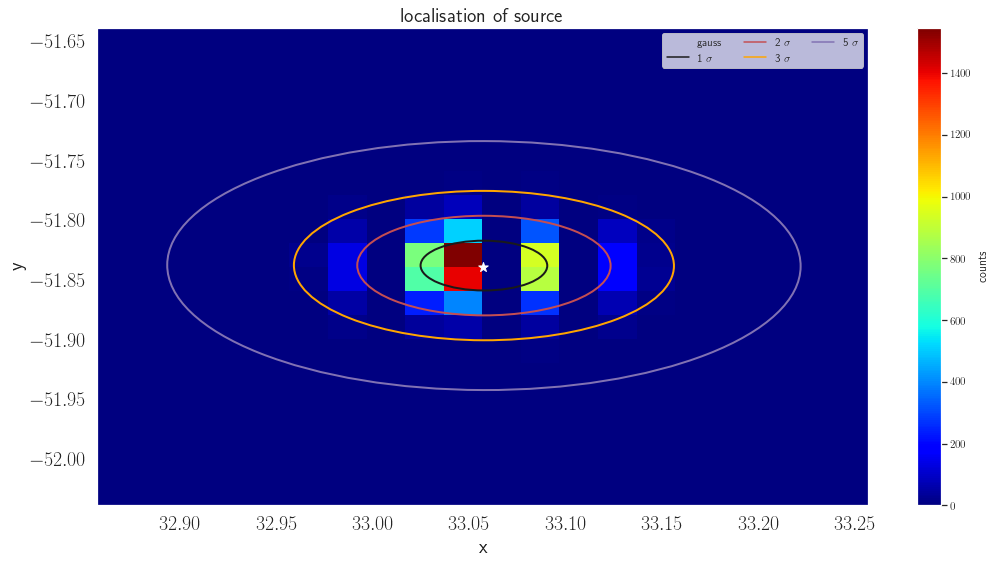


================ texp = 5s ==============

* verify trials =  10000
* drop duplicate => trials =  10000
* drop nan => trials =  10000
! NaN DETECTION RATE : 0.0 %
! DETECTION RATE : 100.0 %
! DET RATIO WITHIN 0.5deg FROM TRUE POSITION: 100.0 %
~ ra det mean: 33.056904346820005 ra det std: 0.01578783960326459
~ dec det mean: -51.84072371452421 dec det std: 0.010827655706497796
~ pos det mean: 0.013351125473031087 pos det gamma: 0.01030698527665251


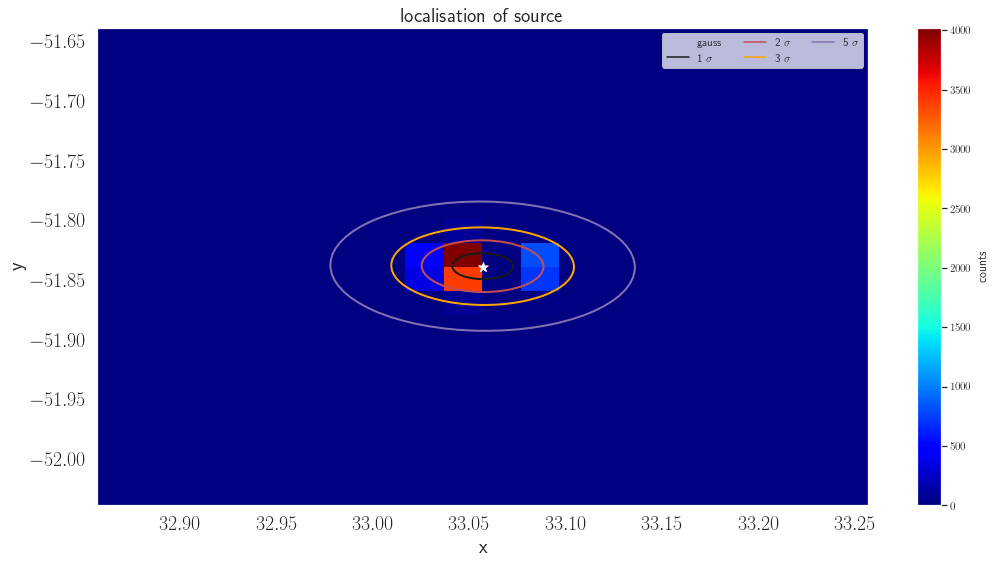


================ texp = 10s ==============

* verify trials =  10000
* drop duplicate => trials =  10000
* drop nan => trials =  10000
! NaN DETECTION RATE : 0.0 %
! DETECTION RATE : 100.0 %
! DET RATIO WITHIN 0.5deg FROM TRUE POSITION: 100.0 %
~ ra det mean: 33.05625065179873 ra det std: 0.010698592238719077
~ dec det mean: -51.84063060295181 dec det std: 0.010019454418006404
~ pos det mean: 0.011392407714010884 pos det gamma: 0.008498050566768747


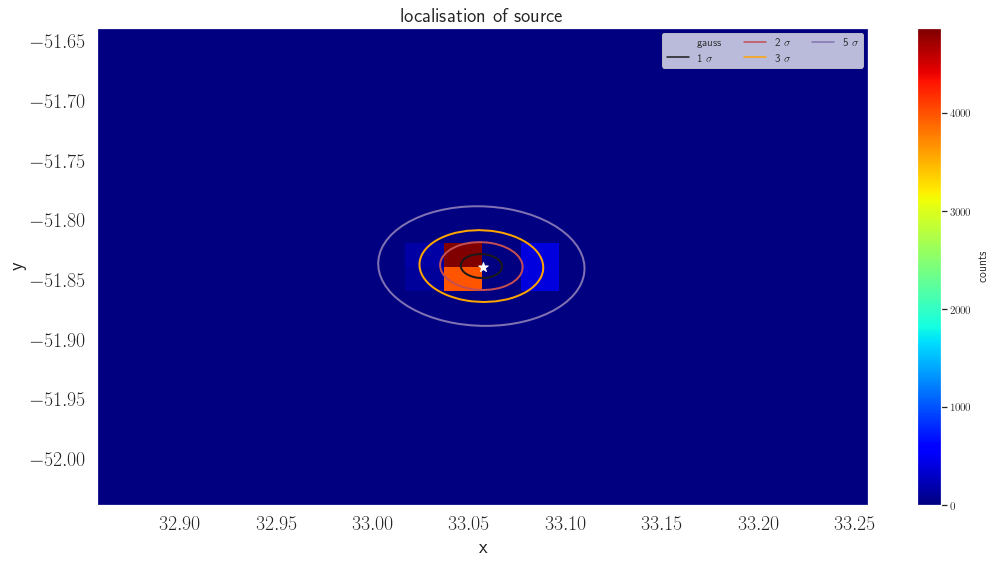


================ texp = 100s ==============

* verify trials =  10000
* drop duplicate => trials =  10000
* drop nan => trials =  10000
! NaN DETECTION RATE : 0.0 %
! DETECTION RATE : 100.0 %
! DET RATIO WITHIN 0.5deg FROM TRUE POSITION: 100.0 %
~ ra det mean: 33.05453778057833 ra det std: 0.0010736324613924986
~ dec det mean: -51.839836722227254 dec det std: 0.00983496447414015
~ pos det mean: 0.010018485560228536 pos det gamma: 0.0071005012700228595


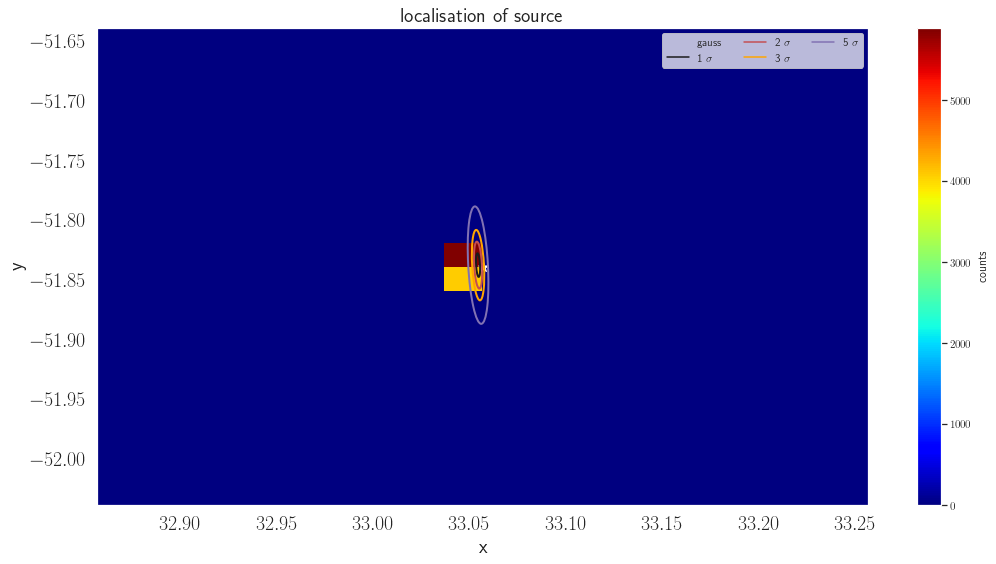

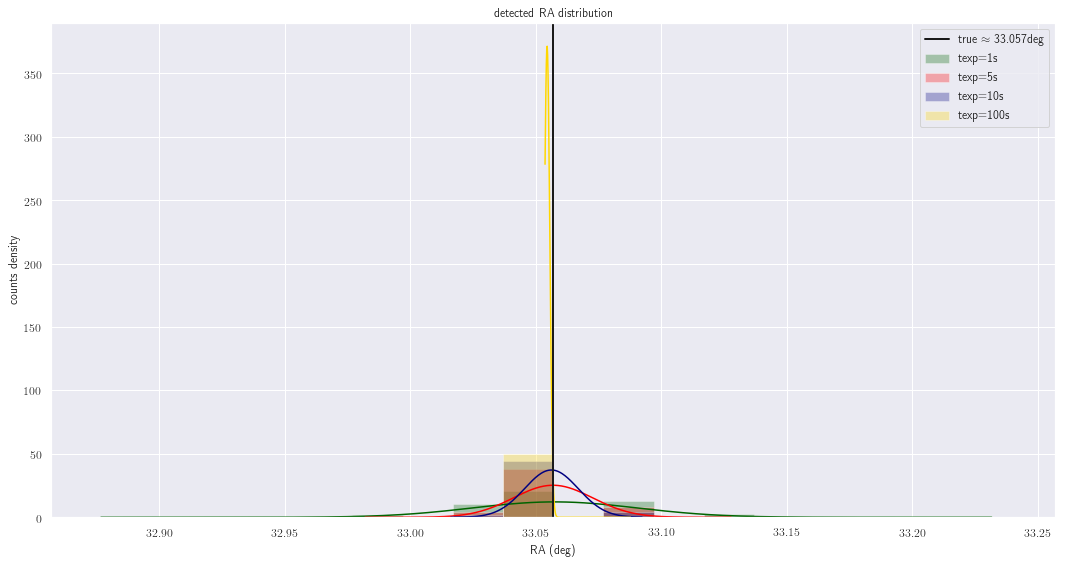

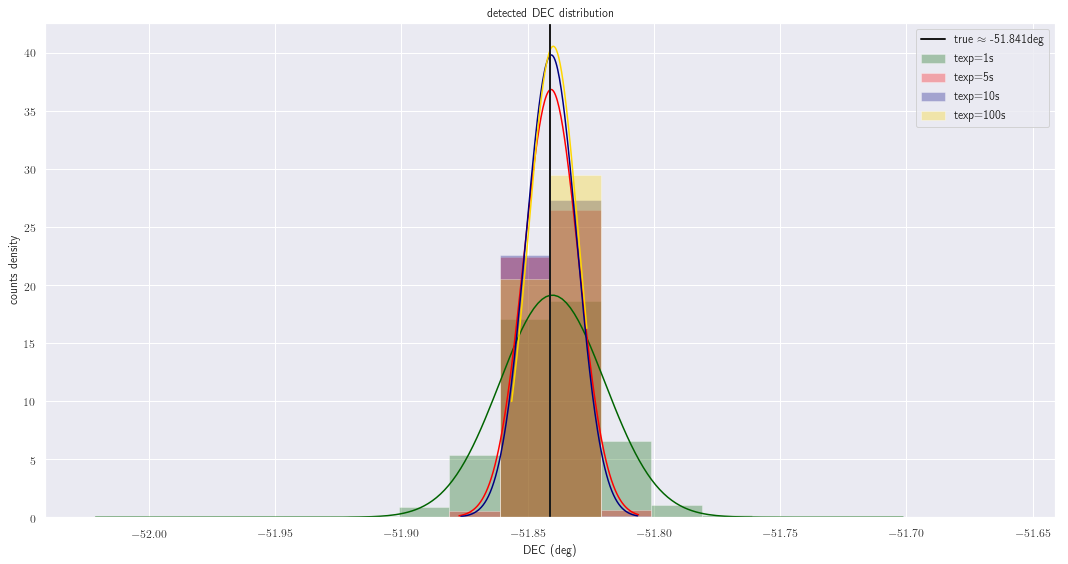

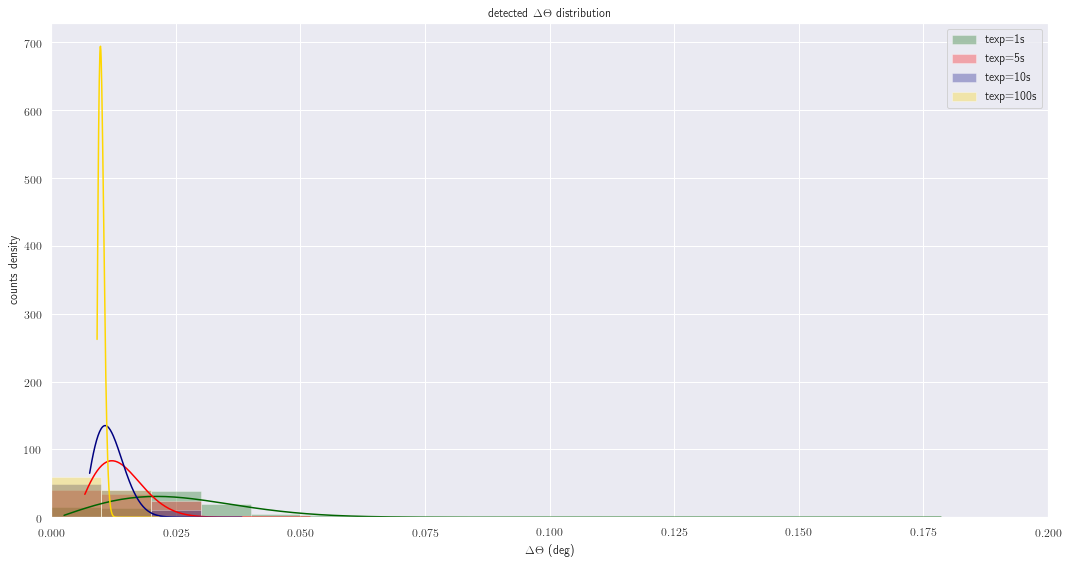

done plotting

tesi_preliminary_nominal_EBL/

================ texp = 1s ==============

* verify trials =  10000
* drop duplicate => trials =  10000
* drop nan => trials =  9543
! NaN DETECTION RATE : 4.569999999999993 %
! DETECTION RATE : 95.43 %
! DET RATIO WITHIN 0.5deg FROM TRUE POSITION: 76.13 %
~ ra det mean: 33.058481312938724 ra det std: 0.055010918671458034
~ dec det mean: -51.839870390988104 dec det std: 0.03360955545597166
~ pos det mean: 0.039443884353464055 pos det gamma: 0.033816533474149126


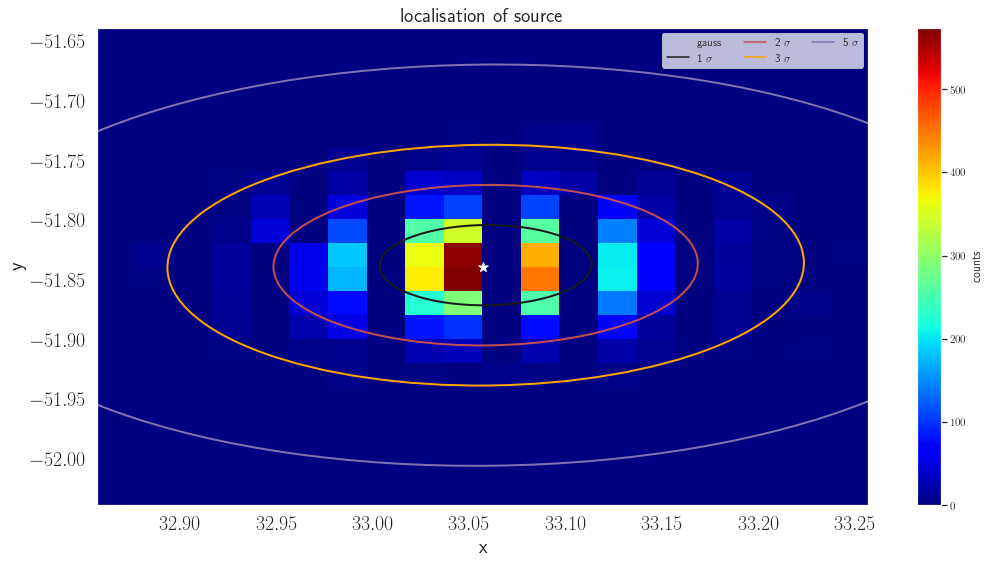


================ texp = 5s ==============

* verify trials =  10000
* drop duplicate => trials =  10000
* drop nan => trials =  9999
! NaN DETECTION RATE : 0.010000000000005116 %
! DETECTION RATE : 99.99 %
! DET RATIO WITHIN 0.5deg FROM TRUE POSITION: 99.99 %
~ ra det mean: 33.05751658864937 ra det std: 0.025867216916258828
~ dec det mean: -51.84072901446484 dec det std: 0.015994003029397755
~ pos det mean: 0.020051069443456564 pos det gamma: 0.01599076500923886


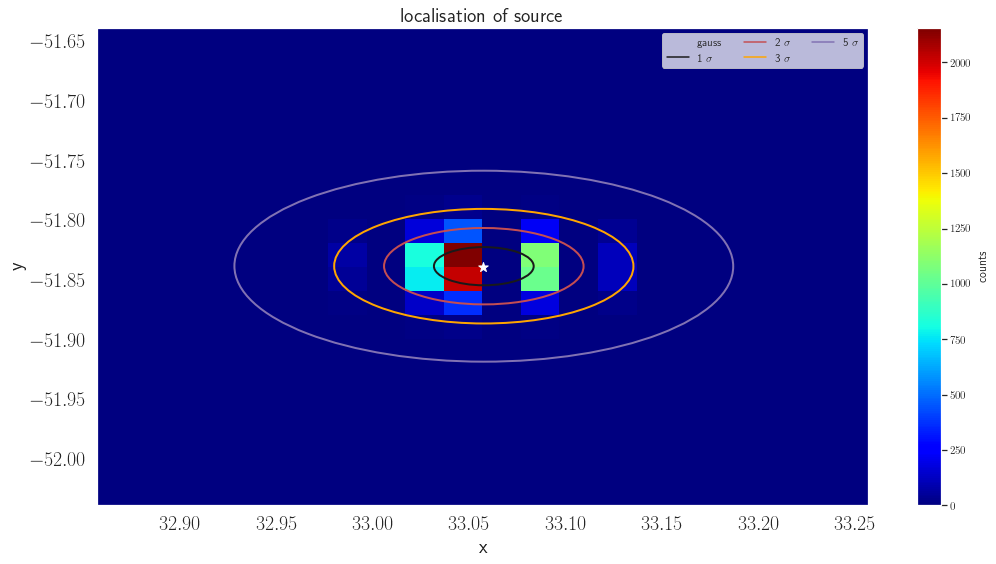


================ texp = 10s ==============

* verify trials =  10000
* drop duplicate => trials =  10000
* drop nan => trials =  10000
! NaN DETECTION RATE : 0.0 %
! DETECTION RATE : 100.0 %
! DET RATIO WITHIN 0.5deg FROM TRUE POSITION: 100.0 %
~ ra det mean: 33.057158219738035 ra det std: 0.019193468797232216
~ dec det mean: -51.84086399472577 dec det std: 0.012040481108904709
~ pos det mean: 0.015252535527247733 pos det gamma: 0.0119504948717758


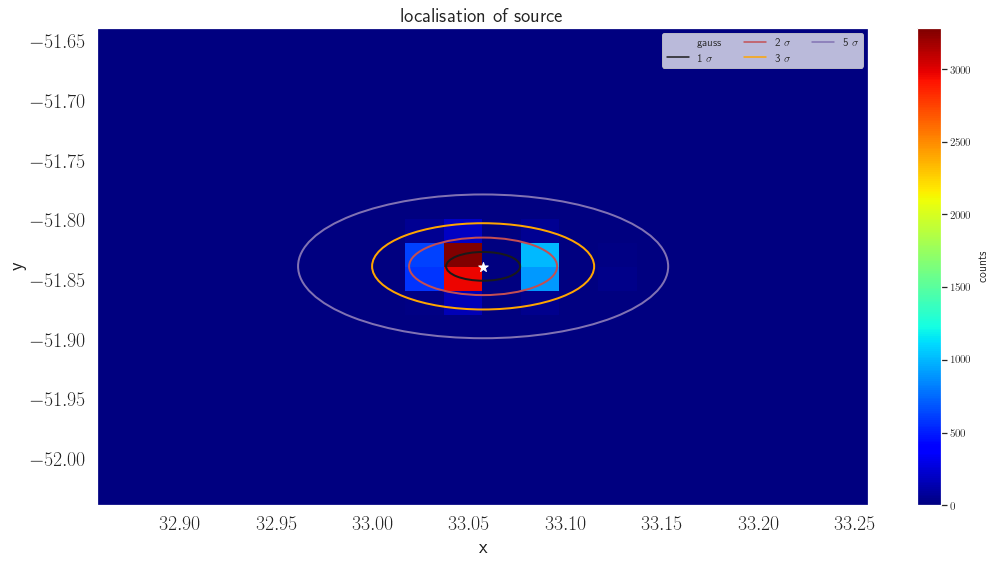


================ texp = 100s ==============

* verify trials =  10000
* drop duplicate => trials =  10000
* drop nan => trials =  10000
! NaN DETECTION RATE : 0.0 %
! DETECTION RATE : 100.0 %
! DET RATIO WITHIN 0.5deg FROM TRUE POSITION: 100.0 %
~ ra det mean: 33.05542795234129 ra det std: 0.0066324767387675974
~ dec det mean: -51.84042133547179 dec det std: 0.009925806620942421
~ pos det mean: 0.01052974350615409 pos det gamma: 0.0076351975470433245


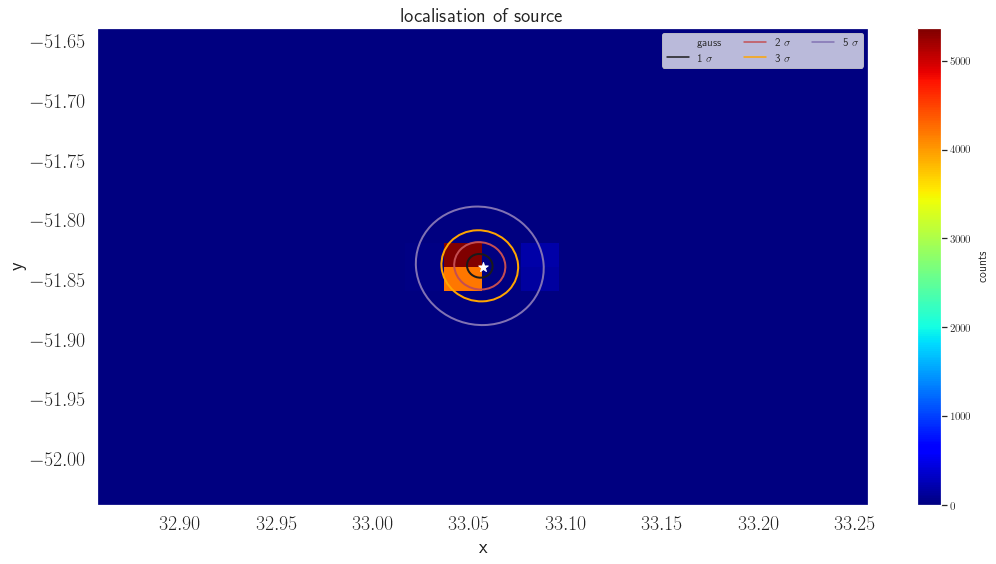

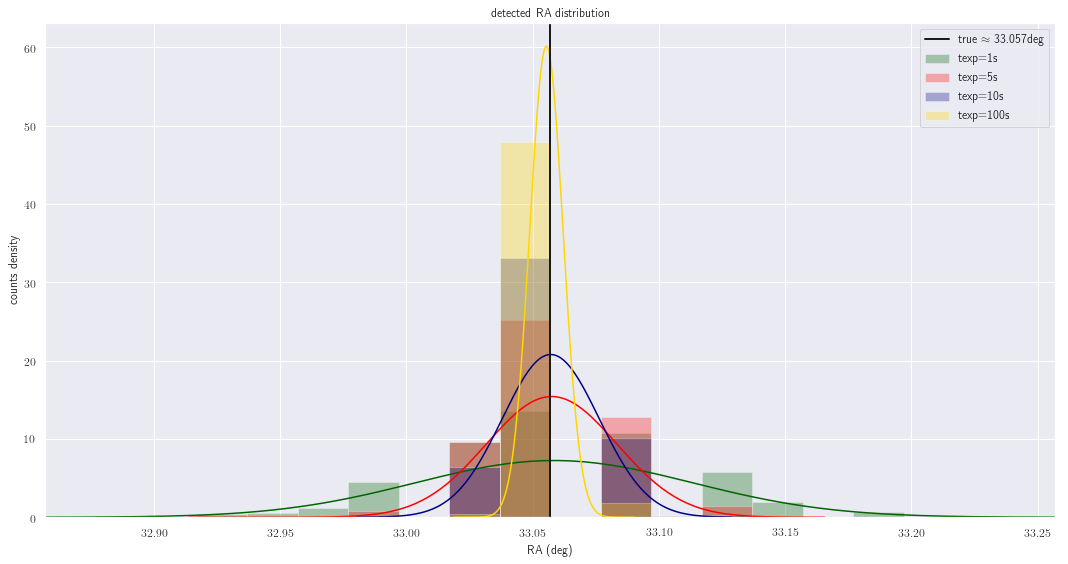

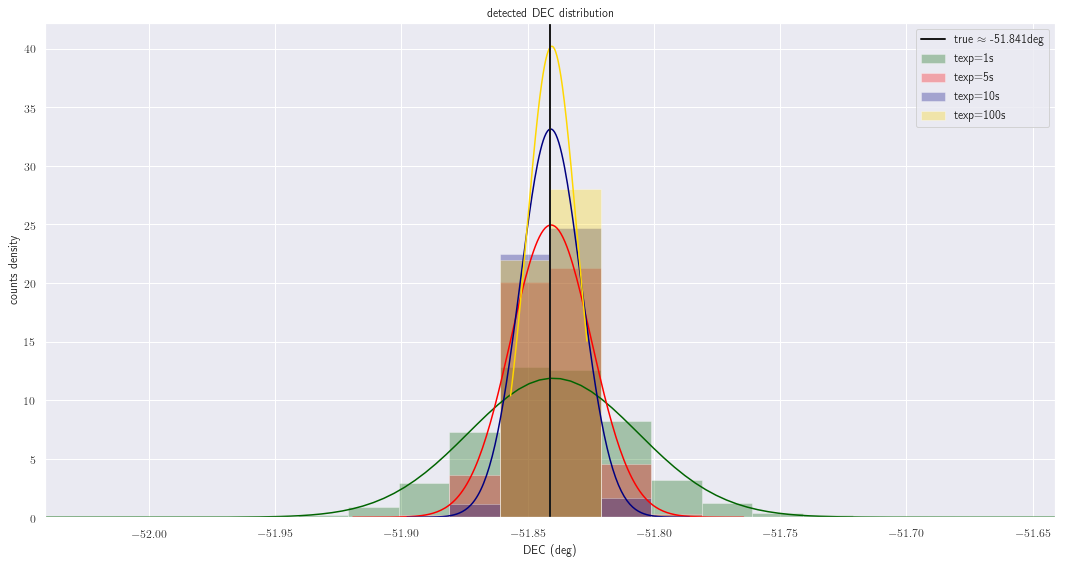

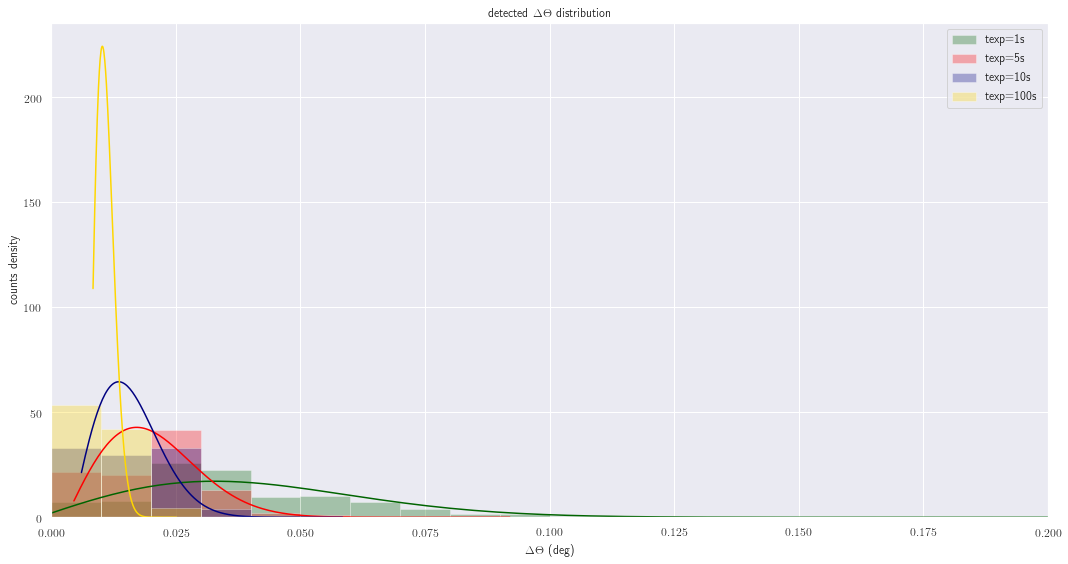

done plotting

tesi_preliminary_degraded_noEBL/

================ texp = 1s ==============

* verify trials =  10000
* drop duplicate => trials =  10000
* drop nan => trials =  9978
! NaN DETECTION RATE : 0.21999999999999886 %
! DETECTION RATE : 99.78 %
! DET RATIO WITHIN 0.5deg FROM TRUE POSITION: 74.27 %
~ ra det mean: 33.05753004704624 ra det std: 0.045147058904487995
~ dec det mean: -51.84035594427709 dec det std: 0.02827552771256372
~ pos det mean: 0.03282233137789097 pos det gamma: 0.028092110366494765


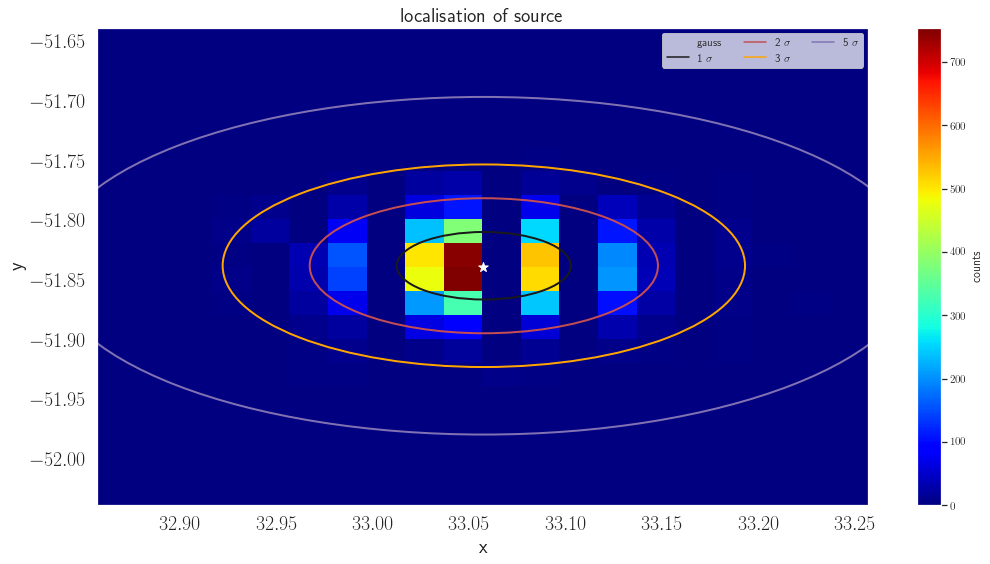


================ texp = 5s ==============

* verify trials =  10000
* drop duplicate => trials =  10000
* drop nan => trials =  10000
! NaN DETECTION RATE : 0.0 %
! DETECTION RATE : 100.0 %
! DET RATIO WITHIN 0.5deg FROM TRUE POSITION: 99.99 %
~ ra det mean: 33.05713557094892 ra det std: 0.02184739434628368
~ dec det mean: -51.84076270622719 dec det std: 0.01359403632313456
~ pos det mean: 0.01709168361305904 pos det gamma: 0.01354743652408479


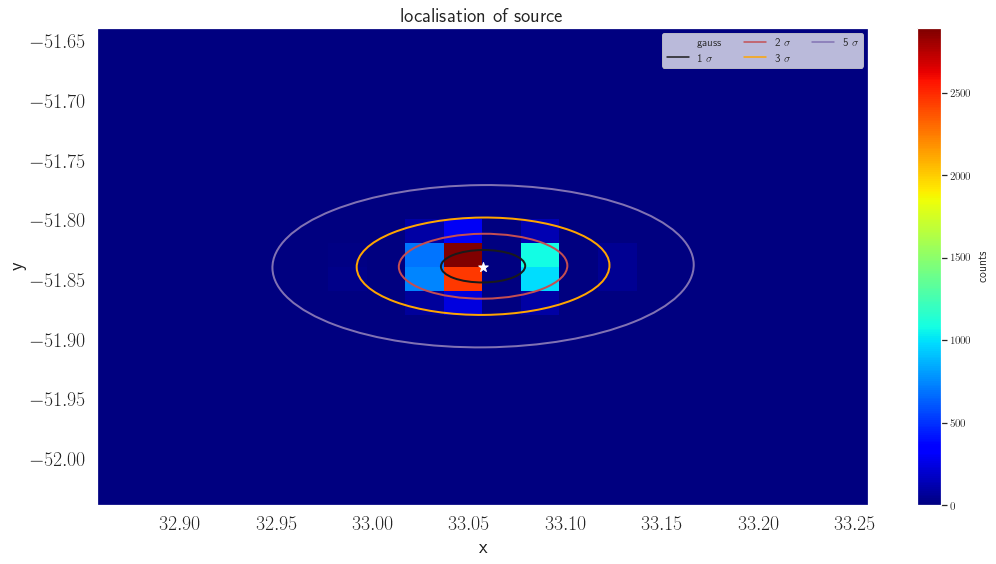


================ texp = 10s ==============

* verify trials =  10000
* drop duplicate => trials =  10000
* drop nan => trials =  10000
! NaN DETECTION RATE : 0.0 %
! DETECTION RATE : 100.0 %
! DET RATIO WITHIN 0.5deg FROM TRUE POSITION: 100.0 %
~ ra det mean: 33.05685942504236 ra det std: 0.01621820194829112
~ dec det mean: -51.84083425004082 dec det std: 0.010839100844365668
~ pos det mean: 0.013516615047310962 pos det gamma: 0.010438599999283668


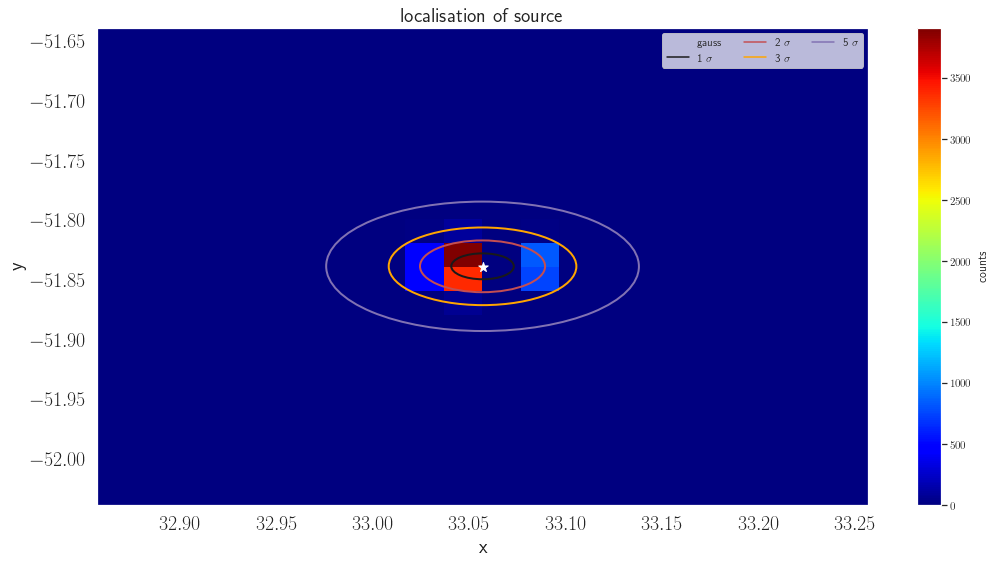


================ texp = 100s ==============

* verify trials =  10000
* drop duplicate => trials =  10000
* drop nan => trials =  10000
! NaN DETECTION RATE : 0.0 %
! DETECTION RATE : 100.0 %
! DET RATIO WITHIN 0.5deg FROM TRUE POSITION: 100.0 %
~ ra det mean: 33.05489303867169 ra det std: 0.004133561544841226
~ dec det mean: -51.84029823232279 dec det std: 0.009907912220901404
~ pos det mean: 0.010219650460619277 pos det gamma: 0.007310143401388814


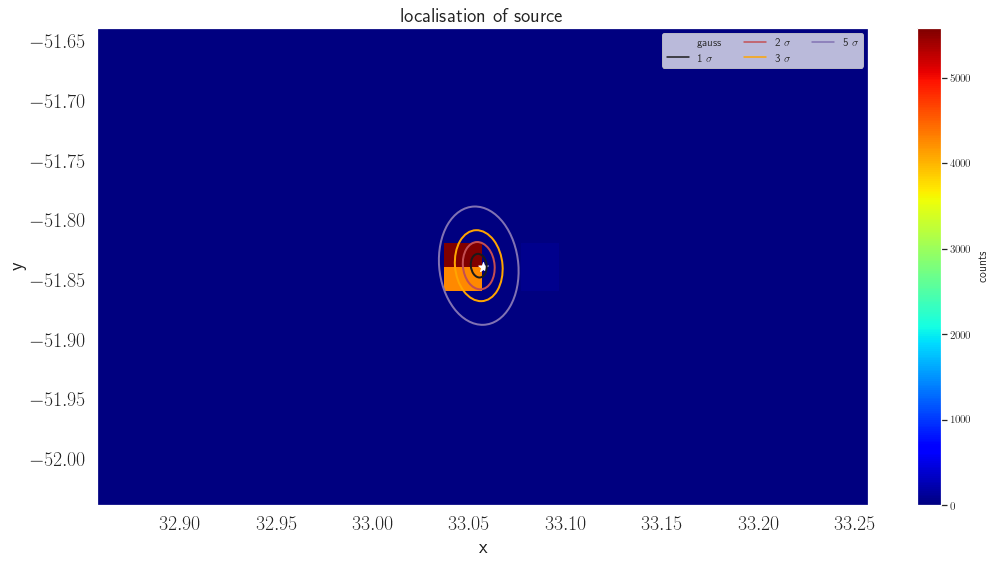

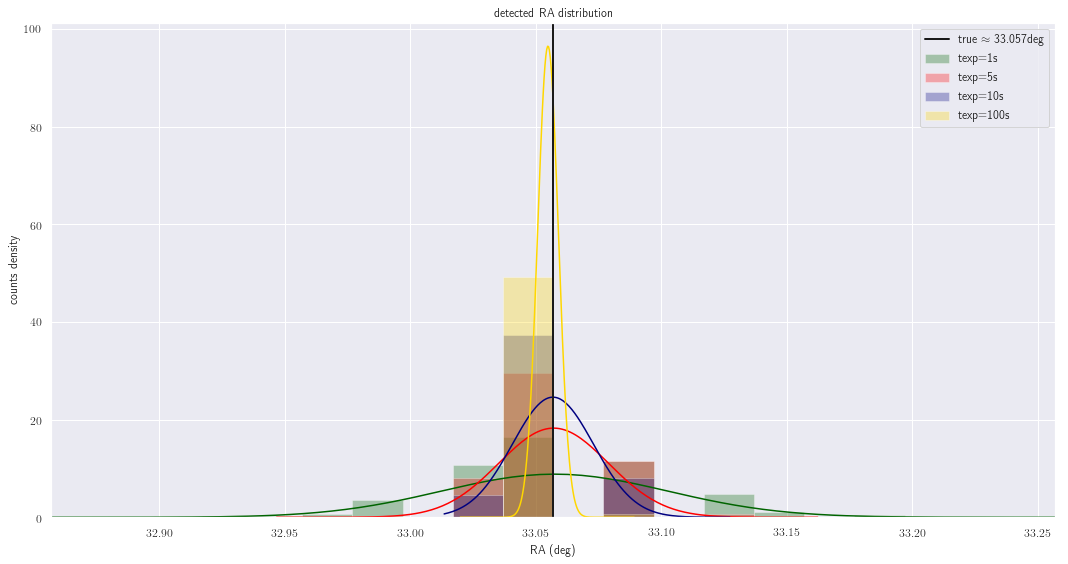

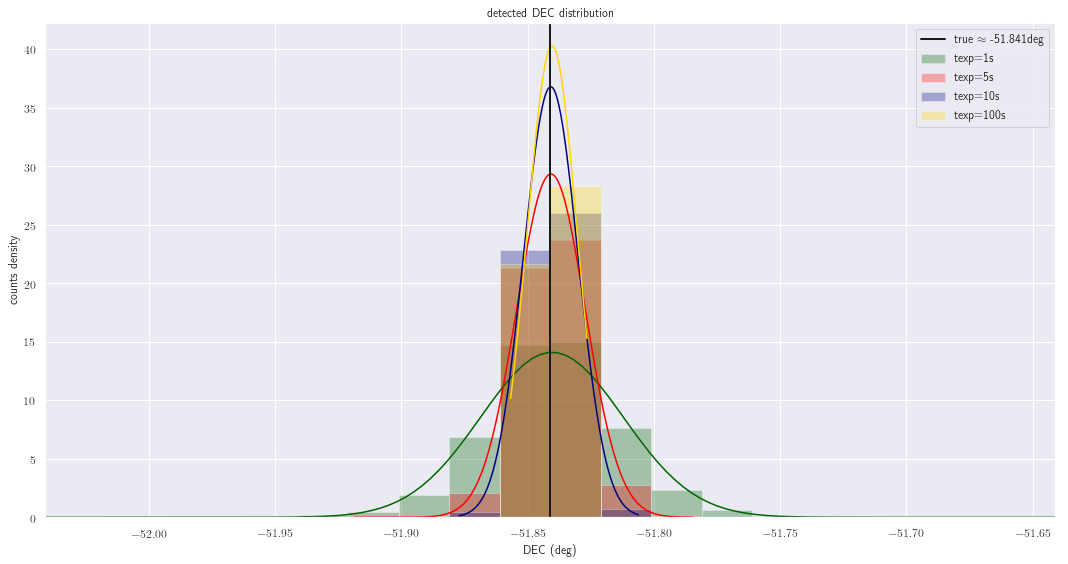

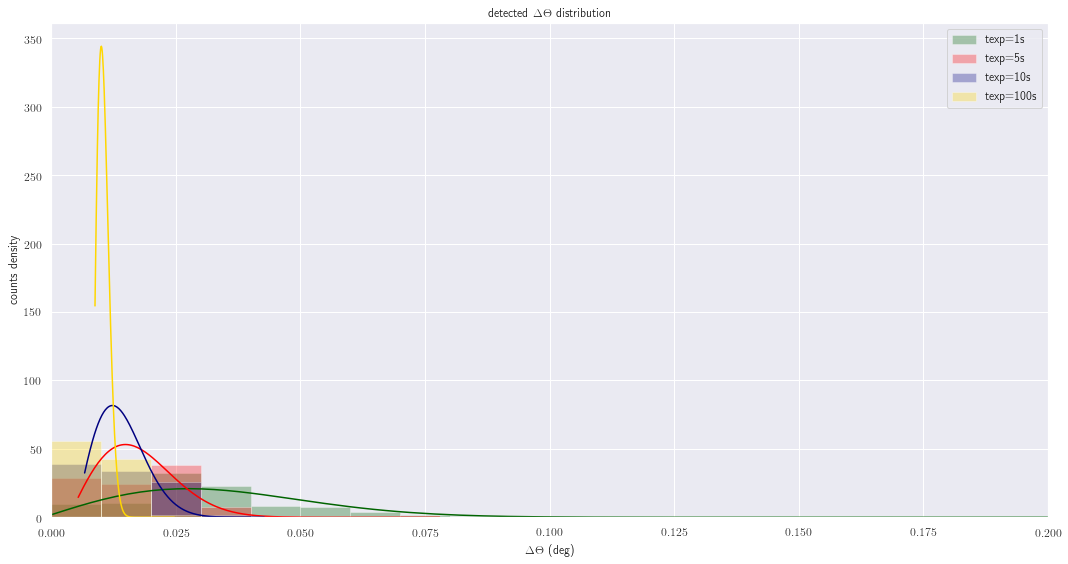

done plotting

tesi_preliminary_degraded_EBL/

================ texp = 1s ==============

* verify trials =  10000
* drop duplicate => trials =  10000
* drop nan => trials =  9924
! NaN DETECTION RATE : 0.7600000000000051 %
! DETECTION RATE : 99.24 %
! DET RATIO WITHIN 0.5deg FROM TRUE POSITION: 39.64 %
~ ra det mean: 33.05903047865634 ra det std: 0.07210368585204463
~ dec det mean: -51.83950648005964 dec det std: 0.04748175151579654
~ pos det mean: 0.05007348713416708 pos det gamma: 0.04606148655914511


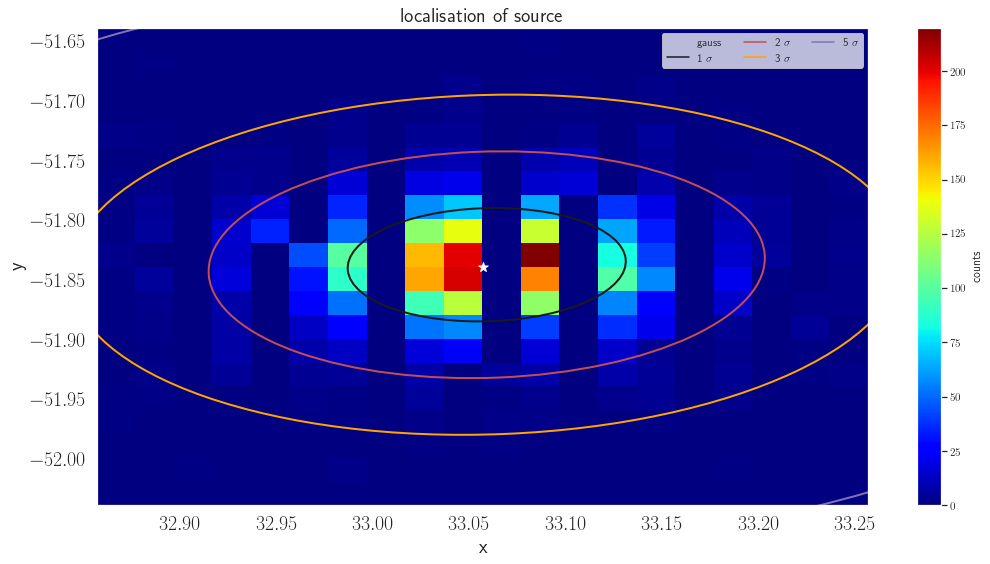


================ texp = 5s ==============

* verify trials =  10000
* drop duplicate => trials =  10000
* drop nan => trials =  9923
! NaN DETECTION RATE : 0.7700000000000102 %
! DETECTION RATE : 99.22999999999999 %
! DET RATIO WITHIN 0.5deg FROM TRUE POSITION: 98.69 %
~ ra det mean: 33.05725676613933 ra det std: 0.036019363596991566
~ dec det mean: -51.840610784546975 dec det std: 0.022288039045893028
~ pos det mean: 0.027417974070940456 pos det gamma: 0.022273165191241263


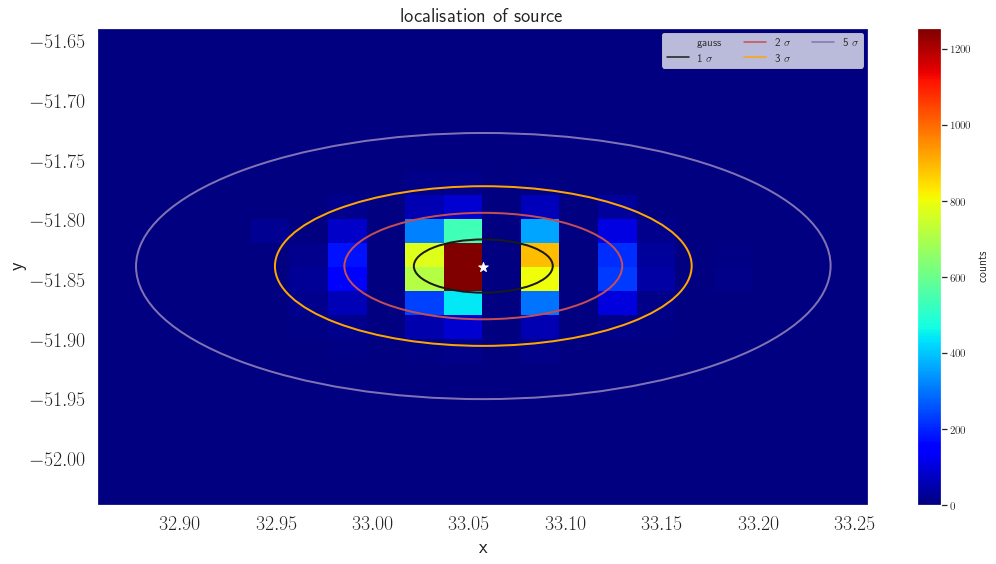


================ texp = 10s ==============

* verify trials =  10000
* drop duplicate => trials =  10000
* drop nan => trials =  10000
! NaN DETECTION RATE : 0.0 %
! DETECTION RATE : 100.0 %
! DET RATIO WITHIN 0.5deg FROM TRUE POSITION: 99.96000000000001 %
~ ra det mean: 33.057366186786396 ra det std: 0.026473733625245344
~ dec det mean: -51.84055943092667 dec det std: 0.016348993160070248
~ pos det mean: 0.020403906088126002 pos det gamma: 0.016356667831011872


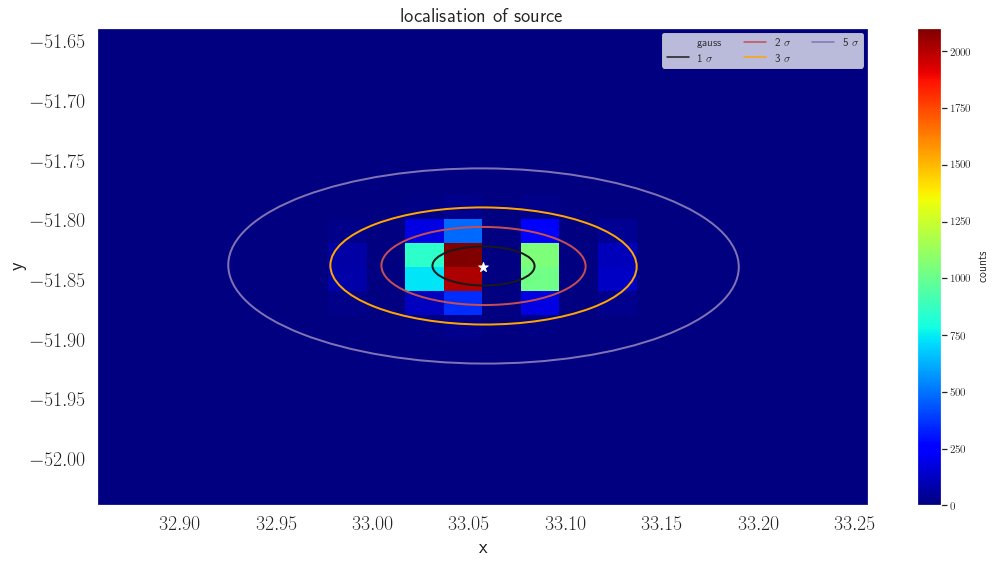


================ texp = 100s ==============

* verify trials =  10000
* drop duplicate => trials =  10000
* drop nan => trials =  10000
! NaN DETECTION RATE : 0.0 %
! DETECTION RATE : 100.0 %
! DET RATIO WITHIN 0.5deg FROM TRUE POSITION: 100.0 %
~ ra det mean: 33.05646774573081 ra det std: 0.01220433564665176
~ dec det mean: -51.84063969033849 dec det std: 0.010092476883757482
~ pos det mean: 0.01183324266939043 pos det gamma: 0.008914990550636416


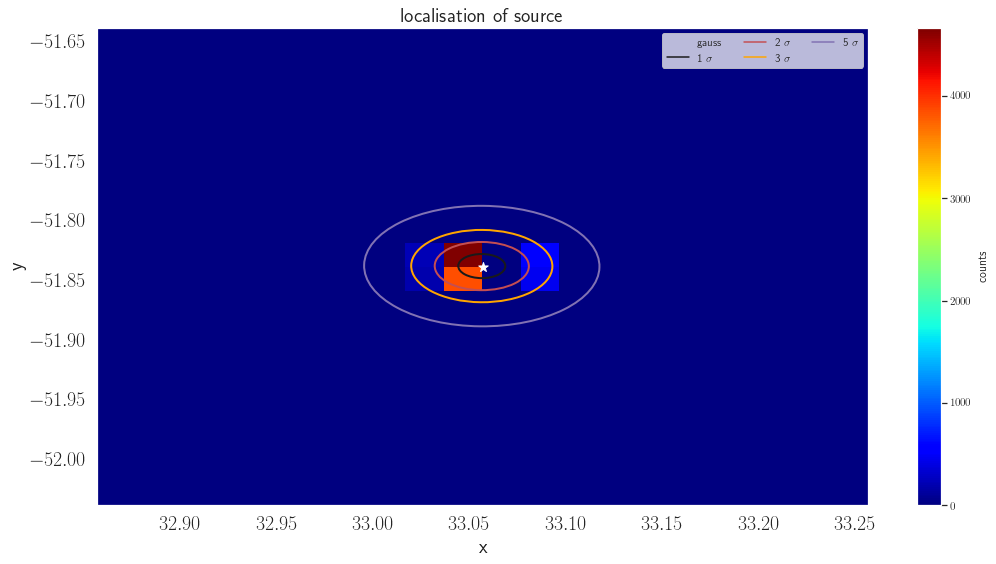

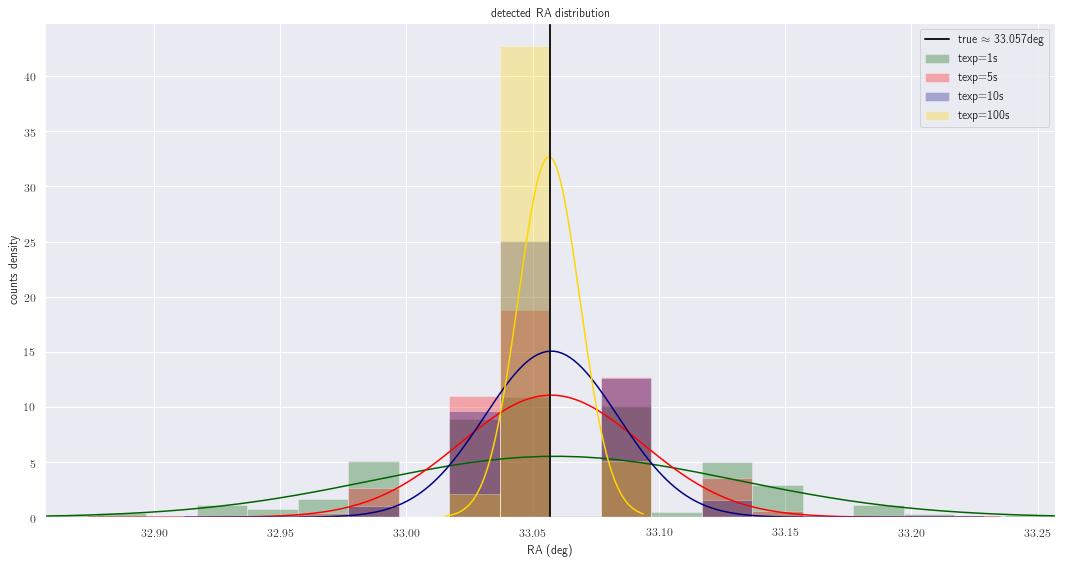

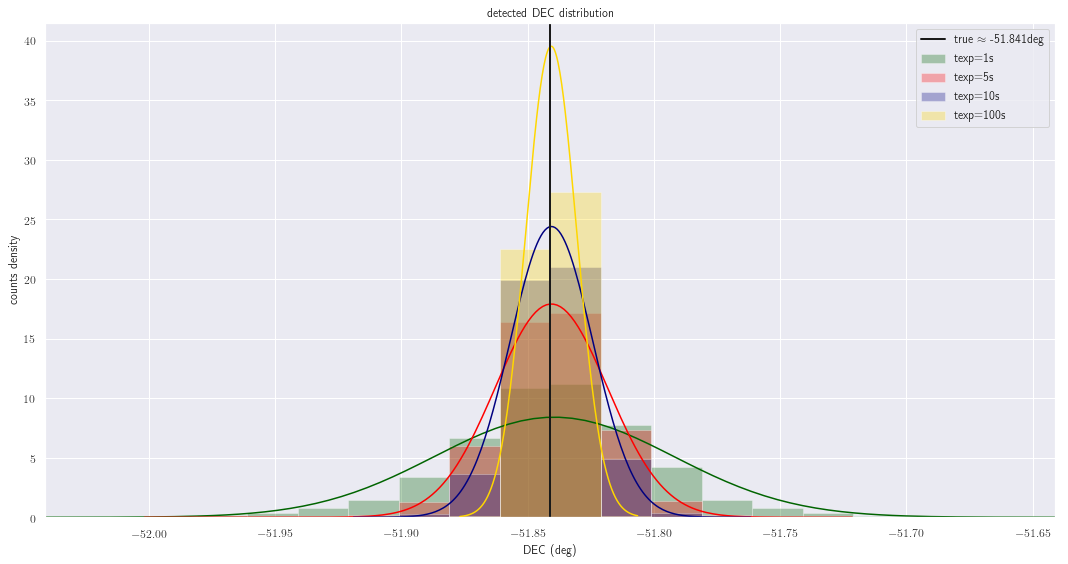

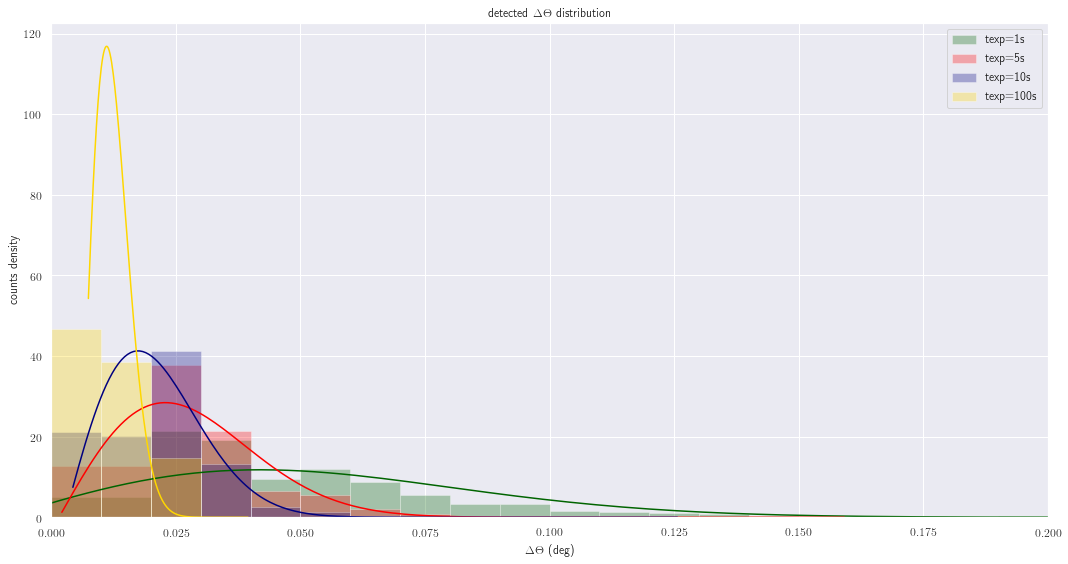

done plotting
done


In [7]:
# =============================
# !!! ALL STATISTICAL PLOTS !!!
# =============================

import matplotlib.pyplot as plt
import seaborn as sns
from astropy import units as u
from astropy.coordinates import SkyCoord
from scipy import stats
from scipy.stats import rayleigh, norm
from matplotlib.lines import Line2D
from matplotlib.patches import Ellipse, Circle, Rectangle
from mpl_toolkits.axes_grid1 import make_axes_locatable
import sys
sys.path.append('/home/ambra/Desktop/cluster-morgana/')
from module_statistics import *
from statistics import mean

for index, f in enumerate(folders):
    print('\n' + f)
    path = directory + f + 'run0406/run0406_ID000126/csv/'
    png_path = directory + f + 'png/'
    if not os.path.isdir(png_path):
        os.mkdir(png_path)
    
    # hist params ---!
    Dwidth = 0.01
    Dnbin = int(threshold / Dwidth)

    list_ra, list_dec, list_pos = ([] for j in range(3))
    list_mode_pos, list_mean_ra, list_mean_dec, list_mean_pos = ([] for j in range(4))
    list_std_ra, list_std_dec = ([] for j in range(2))
    
    for n in range(len(texp)) :  

        # store values ---!
        filename = csvMerged[n]
        print('\n================ texp = %ds ==============\n' %texp[n])

        # load DataFrame and column names ---!
        df = pd.read_csv(path+filename)
        cols = list(df.columns)
        trials = len(df[cols[0]])
        print('* verify trials = ', trials)  
        # dropping ALL duplicte values 
        df.drop_duplicates(subset=cols[0], keep='last', inplace=False) 
        trials = len(df[cols[0]])
        print('* drop duplicate => trials = ', trials) 
        total = trials
        # drop NaN ---!
        df = df.dropna()
        trials = len(df[cols[0]])
        #df = df.reindex(np.arange(trials))
        print('* drop nan => trials = ', trials)  
        perc = 100 * (trials/total)
        print('! NaN DETECTION RATE :', 100-perc, '%')

        trial = np.array(df[cols[0]])
        raDet = np.array(df[cols[-2]])
        decDet = np.array(df[cols[-1]])

        perc = 100 * (trials/total)
        print('! DETECTION RATE :', perc, '%')

        # DETECTION ---!
        distance_det = []
        d_det = []
        ra_det = []
        dec_det = []

        for i in range(len(raDet)) :
            if -90 <= decDet[i] and decDet[i] <= 90 and 0 <= raDet[i] and raDet[i] <= 360 :
                det_coord = SkyCoord(ra = raDet[i]*u.deg, dec = decDet[i]*u.deg, frame='fk5')
                dist = float(true_coord.separation(det_coord).deg)
                distance_det.append(dist)                  

                if dist < threshold :
                    d_det.append(dist)
                    ra_det.append(raDet[i]) 
                    dec_det.append(decDet[i]) 

        perc_det = len(d_det)/total * 100
        print('! DET RATIO WITHIN %.1fdeg FROM TRUE POSITION:' %threshold, perc_det, '%')

        # MEAN DET ---!
        mean_raDet = np.nanmean(ra_det)
        std_raDet = np.nanstd(ra_det)
        mean_decDet = np.nanmean(dec_det)
        std_decDet = np.nanstd(dec_det)
        mean_posDet = np.nanmean(d_det)

        tmp = 0
        for i in range(len(d_det)) :
            tmp += d_det[i]**2

        if len(d_det) != 0.0 :
            mode_det = np.sqrt(1/(2*len(d_det)) * tmp)   
            MLE_det = 0.606/mode_det
        else:
            mode_det = np.nan
            MLE_det = np.nan
            
        print('~ ra det mean:', mean_raDet, 'ra det std:', std_raDet)
        print('~ dec det mean:', mean_decDet, 'dec det std:', std_decDet)
        print('~ pos det mean:', mean_posDet, 'pos det gamma:', mode_det)
        
        # PLOT MAP 2D ---!
        mappage(ra_det, dec_det, trueRA, trueDEC)

        list_ra.append(ra_det)
        list_dec.append(dec_det)
        list_pos.append(d_det)
        list_mean_ra.append(mean_raDet)
        list_mean_dec.append(mean_decDet)
        list_mean_pos.append(mean_posDet)
        list_std_ra.append(std_raDet)
        list_std_dec.append(std_decDet)
        list_mode_pos.append(mode_det)

    # PLOT HIST GATHERED BY TEXP ---!
    plottage(texp, list_ra, list_dec, list_pos, list_std_ra, list_std_dec, list_mode_pos, 
             trueRA, trueDEC, png_path)
    print('done plotting')
print('done')

In [21]:
# no EBL (nom, deg) ---!
ra = [[33.057, 33.057, 33.057, 33.056], [33.057, 33.057, 33.057, 33.055]]
dec = [[-51.840, -51.841, -51.840, -51.840], [-51.840, -51.841, -51.841, -51.840]]
std_ra = [[0.045, 0.022, 0.016, 0.004], [0.045, 0.022, 0.016, 0.004]]
std_dec = [[0.028, 0.013, 0.011, 0.009], [0.028, 0.013, 0.011, 0.010]]
pos = [[0.021, 0.010, 0.008, 0.007], [0.028, 0.013, 0.010, 0.007]]
nan_detections = [[0.35, 0.0, 0.0, 0.0], [0.22, 0.0, 0.0, 0.0]]
near_detections = [[97.71, 100.0, 100.0, 100.0], [74.27, 99.99, 100.0, 100.0]]
      
# EBL (nom, deg) ---!
ra2 = [[33.058, 33.057, 33.057, 33.055], [33.059, 33.057, 33.057, 33.056]]
dec2 = [[-51.840, -51.841, -51.841, -51.840], [-51.839, -51.841, -51.840, -51.841]]
std_ra2 = [[0.055, 0.025, 0.019, 0.007], [0.072, 0.036, 0.026, 0.012]]
std_dec2 = [[0.034, 0.016, 0.012, 0.010], [0.047, 0.022, 0.016, 0.010]]
pos2 = [[0.034, 0.016, 0.012, 0.008], [0.046, 0.022, 0.016, 0.008]]
nan_detections2 = [[4.57, 0.01, 0.0, 0.0], [0.76, 0.77, 0.0, 0.0]]
near_detections2 = [[76.13, 99.99, 100.0, 100.0], [39.64, 98.69, 99.96, 100.0]]

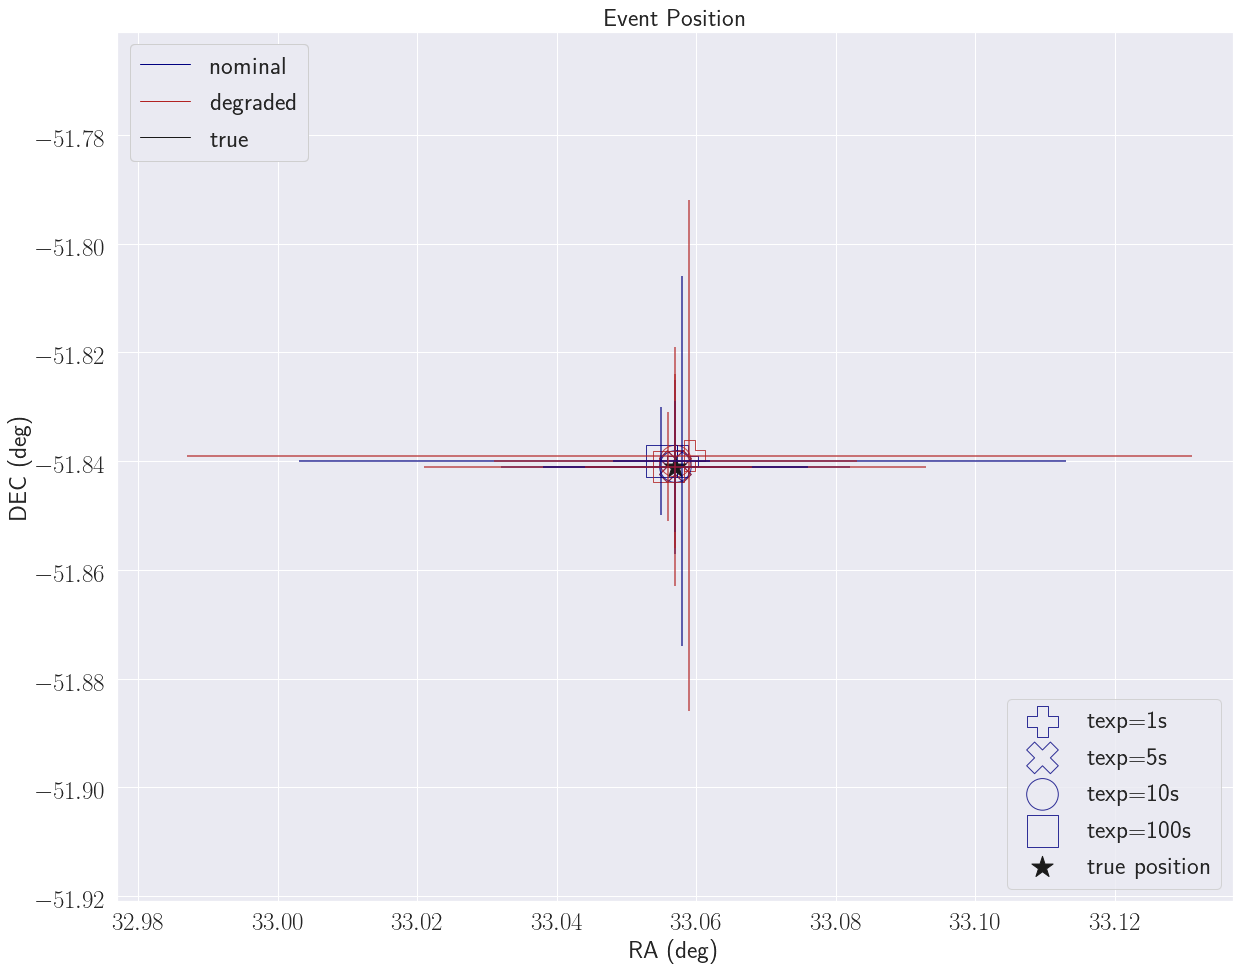

In [95]:
png_path = '/home/ambra/Desktop/cluster-morgana/archive_tests/tesi_01_preliminary/png/'
if not os.path.isdir(png_path):
    os.system('mkdir ' + png_path)


plottage2(texp, ra2, dec2, std_ra2, std_dec2, trueRA, trueDEC, png_path)

In [ ]:
png_path = '/home/ambra/Desktop/cluster-morgana/archive_tests/tesi_01_preliminary/png/'

c = ['navy', 'firebrick']
alpha = 0.5    
# img params ---!
fontsize=25
figsize=(20, 16)
leglabel = ['nominal', 'degraded']
markers = ['P', 'X', 'v', '^']


fig = plt.figure(figsize=figsize)
plt.rc('text', usetex=True)
sns.set()

ax = plt.subplot(111, xscale='log')
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
for i in range(len(pos2)):
    plt.plot(texp, pos2[i], markersize=20, marker=markers[i], label=leglabel[i], alpha=alpha, c=c[i])    
    #plt.errorbar(ra[i], dec[i], xerr=std_ra[i], yerr=std_dec[i], fmt='%s.' %c[i], alpha=alpha)

#plt.scatter(trueRA, trueDEC, s=10**2, marker='*', label='true position', alpha=1, c='k')
#plt.axis([trueRA-0.1, trueRA+0.1, trueDEC-0.1, trueDEC+0.1])
plt.title('distance of detection from true position', fontsize=fontsize)
plt.ylabel('$\Delta$$\Theta$ (deg)', fontsize=fontsize)
plt.xlabel('exposure time (s)', fontsize=fontsize)
legend1 = plt.legend(loc=0, fontsize=fontsize)
#ax.add_artist(legend1)

custom_lines = [Line2D([0], [0], color=c[0], lw=1),
                Line2D([0], [0], color=c[1], lw=1),
                Line2D([0], [0], color='k', lw=1)]

#legend2 = plt.legend(custom_lines, ['nominal', 'degraded', 'true'], loc=0, fontsize=fontsize)
#ax.add_artist(legend2)

# save only subplot with padding
plt.savefig(png_path+'run0406_distVStexp_nomVSdeg.png')
plt.show()
plt.close()